In [31]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

import scipy.io
from utils import log_gaussian_loss, gaussian, get_kl_Gaussian_divergence

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: {}'.format(device))

device: cuda


In [32]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior

        scale = (2 / self.input_dim) ** 0.5
        rho_init = np.log(np.exp((2 / self.input_dim) ** 0.5) - 1)

        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -2))

        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-3, -2))

    def forward(self, x, sample=True):

        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = self.weight_mus.data.new(self.weight_mus.size()).normal_()
            bias_epsilons = self.bias_mus.data.new(self.bias_mus.size()).normal_()

            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))

            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons * weight_stds
            bias_sample = self.bias_mus + bias_epsilons * bias_stds
            output = torch.mm(x, weight_sample) + bias_sample

            # computing the KL loss term
            KL_loss_weight = get_kl_Gaussian_divergence(self.prior.mu, self.prior.sigma**2, self.weight_mus, weight_stds**2)
            KL_loss_bias = get_kl_Gaussian_divergence(self.prior.mu, self.prior.sigma**2, self.bias_mus, bias_stds**2)
            KL_loss = KL_loss_weight + KL_loss_bias

            return output, KL_loss
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss

    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())

            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))

            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons * weight_stds

            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()

        return all_samples

In [33]:
class BBP_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units):
        super(BBP_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim + 1

        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, no_units, gaussian(0, 1))
        self.layer3 = BayesLinear_Normalq(no_units, no_units, gaussian(0, 1))
        self.layer4 = BayesLinear_Normalq(no_units, no_units, gaussian(0, 1))
        self.layer5 = BayesLinear_Normalq(no_units, no_units, gaussian(0, 1))
        self.layer6 = BayesLinear_Normalq(no_units, no_units, gaussian(0, 1))
        self.layer7 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))

        # activation to be used between hidden layers
        self.activation = nn.Tanh()

    def forward(self, x):

        KL_loss_total = 0
        x = x.view(-1, self.input_dim)

        x, KL_loss = self.layer1(x)
        x = self.activation(x)
        KL_loss_total += KL_loss

        x, KL_loss = self.layer2(x)
        x = self.activation(x)
        KL_loss_total += KL_loss

        x, KL_loss = self.layer3(x)
        x = self.activation(x)
        KL_loss_total += KL_loss

        x, KL_loss = self.layer4(x)
        x = self.activation(x)
        KL_loss_total += KL_loss

        x, KL_loss = self.layer5(x)
        x = self.activation(x)
        KL_loss_total += KL_loss

        x, KL_loss = self.layer6(x)
        x = self.activation(x)
        KL_loss_total += KL_loss

        x, KL_loss = self.layer7(x)
        KL_loss_total += KL_loss

        return x, KL_loss_total

In [34]:
class BBP_Model_PINN:
    def __init__(self, xt_lb, xt_ub, u_lb, u_ub,
                 input_dim, output_dim, no_units,
                 learn_rate, batch_size, no_batches,
                 prior_lambda1, prior_lambda2, num_epochs):

        
        self.xt_lb = torch.from_numpy(xt_lb).float().to(device)
        self.xt_ub = torch.from_numpy(xt_ub).float().to(device)
        self.u_lb = torch.from_numpy(u_lb).float().to(device)
        self.u_ub = torch.from_numpy(u_ub).float().to(device)


        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches

        self.network = BBP_Model(input_dim = input_dim, output_dim = output_dim,
                                    no_units = no_units)


        self.prior_lambda1 = prior_lambda1
        self.prior_lambda2 = prior_lambda2

        self.lambda1_mus = nn.Parameter(torch.Tensor(1).uniform_(0, 2))
        self.lambda1_rhos = nn.Parameter(torch.Tensor(1).uniform_(-3, 2))
        self.lambda2_mus = nn.Parameter(torch.Tensor(1).uniform_(0, 0.05))
        self.lambda2_rhos = nn.Parameter(torch.Tensor(1).uniform_(-3, -2))

        self.network.register_parameter('lambda1_mu', self.lambda1_mus)
        self.network.register_parameter('lambda2_mu', self.lambda2_mus)
        self.network.register_parameter('lambda1_rho', self.lambda1_rhos)
        self.network.register_parameter('lambda2_rho', self.lambda2_rhos)

        self.network = self.network.to(device)

        # self.optimizer = torch.optim.SGD(self.network.parameters(), lr = self.learn_rate)
        self.optimizer = torch.optim.AdamW(self.network.parameters(), lr = self.learn_rate)
        # self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr = 1e-3, 
        #                                     steps_per_epoch = no_batches, epochs = num_epochs)
        self.loss_func = log_gaussian_loss

    def net_U(self, x, t):
        xt = torch.cat((x,t), dim=1)
        xt = 2*(xt-self.xt_lb)/(self.xt_ub-self.xt_lb) - 1
        out, KL_loss = self.network(xt)

        u = out[:,0:1]
        log_noise_u = out[:,1:2]
        # log_noise_f = out[:,2:3]
        return u, log_noise_u, KL_loss

    def net_F(self, x, t, lambda1_sample, lambda2_sample):
        lambda_1 = lambda1_sample        
        lambda_2 = torch.exp(lambda2_sample)

        u, _, _ = self.net_U(x, t)
        u = u*(self.u_ub-self.u_lb) + self.u_lb # reverse scaling

        u_t = torch.autograd.grad(u, t, torch.ones_like(u),
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u),
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]

        # F = u_t + 1*u*u_x - (0.01/np.pi)*u_xx
        F = u_t + lambda_1*u*u_x - lambda_2*u_xx
        return F

    def fit(self, X, t, U, no_samples):
        self.network.train()

        # X = torch.tensor(self.X, requires_grad=True).float().to(device)
        # t = torch.tensor(self.t, requires_grad=True).float().to(device)
        U = (U-self.u_lb)/(self.u_ub-self.u_lb) # scaling

        # reset gradient and total loss
        self.optimizer.zero_grad()

        fit_loss_total = 0
        fit_loss_F_total = 0
        fit_loss_U_total = 0

        for i in range(no_samples):
            lambda1_epsilons = self.lambda1_mus.data.new(self.lambda1_mus.size()).normal_()
            lambda1_stds = torch.log(1 + torch.exp(self.lambda1_rhos))
            lambda2_epsilons = self.lambda2_mus.data.new(self.lambda2_mus.size()).normal_()
            lambda2_stds = torch.log(1 + torch.exp(self.lambda2_rhos))

            lambda1_sample = self.lambda1_mus + lambda1_epsilons * lambda1_stds
            lambda2_sample = self.lambda2_mus + lambda2_epsilons * lambda2_stds

            u_pred, log_noise_u, KL_loss_para = self.net_U(X, t)
            f_pred = self.net_F(X, t, lambda1_sample, lambda2_sample)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_U_total += self.loss_func(u_pred, U, log_noise_u.exp(), self.network.output_dim)
            fit_loss_F_total += torch.sum(f_pred**2) ######
            # fit_loss_F_total += self.loss_func(f_pred, torch.zeros_like(f_pred), self.network.log_noise_f.exp(), self.network.output_dim)

        KL_loss_lambda1 = get_kl_Gaussian_divergence(self.prior_lambda1.mu, self.prior_lambda1.sigma**2, self.lambda1_mus, lambda1_stds**2)
        KL_loss_lambda2 = get_kl_Gaussian_divergence(self.prior_lambda2.mu, self.prior_lambda2.sigma**2, self.lambda2_mus, lambda2_stds**2)
        KL_loss_total = KL_loss_para + KL_loss_lambda1 + KL_loss_lambda2

        # KL_loss_total = KL_loss_para 
        # minibatches and KL reweighting
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (KL_loss_total + fit_loss_U_total + fit_loss_F_total) / (no_samples*X.shape[0])
        
        total_loss.backward()
        self.optimizer.step()
        # self.scheduler.step()

        return fit_loss_U_total/no_samples, fit_loss_F_total/no_samples, KL_loss_total, total_loss

    def predict(self, xt, no_sample, best_net):
        xt = torch.tensor(xt, requires_grad=True).float().to(device)
        xt = 2*(xt-self.xt_lb)/(self.xt_ub-self.xt_lb) - 1

        self.network.eval()
        samples = []
        noises = []
        for i in range(no_sample):
            out_pred, _ = best_net(xt)
            u_pred = out_pred[:,0:1]
            log_noise_u = out_pred[:,1:2]
            u_pred = u_pred*(self.u_ub-self.u_lb) + self.u_lb # reverse scaling

            samples.append(u_pred.detach().cpu().numpy())
            noises.append(log_noise_u.exp().detach().cpu().numpy())
        return np.array(samples), np.array(noises)

    def sample_F(self, xt, no_samples = 100):
        xt = torch.tensor(xt, requires_grad=True).float().to(device)
        xt = 2*(xt-self.xt_lb)/(self.xt_ub-self.xt_lb) - 1
        self.network.eval()

        samples = []
        for _ in range(no_samples):
            lambda1_epsilons = self.lambda1_mus.data.new(self.lambda1_mus.size()).normal_()
            lambda1_stds = torch.log(1 + torch.exp(self.lambda1_rhos))
            lambda2_epsilons = self.lambda2_mus.data.new(self.lambda2_mus.size()).normal_()
            lambda2_stds = torch.log(1 + torch.exp(self.lambda2_rhos))

            lambda1_sample = self.lambda1_mus + lambda1_epsilons * lambda1_stds
            lambda2_sample = self.lambda2_mus + lambda2_epsilons * lambda2_stds
            f = self.net_F(xt[:,0:1], xt[:,1:2], lambda1_sample, lambda2_sample)
            samples.append(f.detach().cpu().numpy().ravel())
        return np.array(samples)



In [35]:
data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None] # 100 x 1
x = data['x'].flatten()[:,None] # 256 x 1
Exact_ = np.real(data['usol']).T # 100 x 256

Exact = Exact_ + np.random.normal(0, 0.1, (100, 256))

X, T = np.meshgrid(x,t) # 100 x 256
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) # 25600 x 2
u_star = Exact.flatten()[:,None]  # 25600 x 1

# Domain bounds of x, t
xt_lb = X_star.min(0)
xt_ub = X_star.max(0)

# training data
N_u = 2000
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]

u_train = u_star[idx,:]

u_lb = u_train.min(0)
u_ub = u_train.max(0)

num_epochs, batch_size = 25000, len(X_u_train),

net = BBP_Model_PINN(xt_lb, xt_ub, u_lb, u_ub,
                     input_dim = 2, output_dim = 1, no_units = 50, learn_rate = 1e-3,
                        batch_size = batch_size, no_batches = 1,
                        prior_lambda1 = gaussian(0, 1), prior_lambda2 = gaussian(0, 1), num_epochs = num_epochs)


In [36]:
fit_loss_U_train = np.zeros(num_epochs)
fit_loss_F_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
loss = np.zeros(num_epochs)
noise = []

best_net, best_loss = None, float('inf')

X = torch.tensor(X_u_train[:,0:1], requires_grad = True, device = device).float()
t = torch.tensor(X_u_train[:,1:2], requires_grad = True, device = device).float()
U = torch.tensor(u_train, requires_grad = True, device = device).float()

X_u_test_25 = np.hstack([x, 0.25*np.ones_like((x))])
target_25 = Exact_[25].reshape(-1,1)

Epoch:     1/25000, total loss = 1.766, Fit loss U = 2201.509, Fit loss F = 1.007, KL loss = 26573.875
Epoch:     1/25000, lambda1_mu = 0.280, lambda2_mu = 1.003, lambda1_std = 0.268, lambda2_std = 0.057
Epoch:     1/25000, error_25 = 2.06232, error_train = 2.30929

Epoch:   101/25000, total loss = 0.926, Fit loss U = 534.863, Fit loss F = 6.919, KL loss = 26196.133
Epoch:   101/25000, lambda1_mu = 0.235, lambda2_mu = 0.965, lambda1_std = 0.264, lambda2_std = 0.063
Epoch:   101/25000, error_25 = 1.00187, error_train = 0.99826

Epoch:   201/25000, total loss = 0.837, Fit loss U = 357.976, Fit loss F = 11.918, KL loss = 26068.117
Epoch:   201/25000, lambda1_mu = 0.238, lambda2_mu = 0.813, lambda1_std = 0.252, lambda2_std = 0.066
Epoch:   201/25000, error_25 = 0.89936, error_train = 0.91156

Epoch:   301/25000, total loss = 0.772, Fit loss U = 236.528, Fit loss F = 9.265, KL loss = 25963.830
Epoch:   301/25000, lambda1_mu = 0.302, lambda2_mu = 0.668, lambda1_std = 0.228, lambda2_std = 0.0

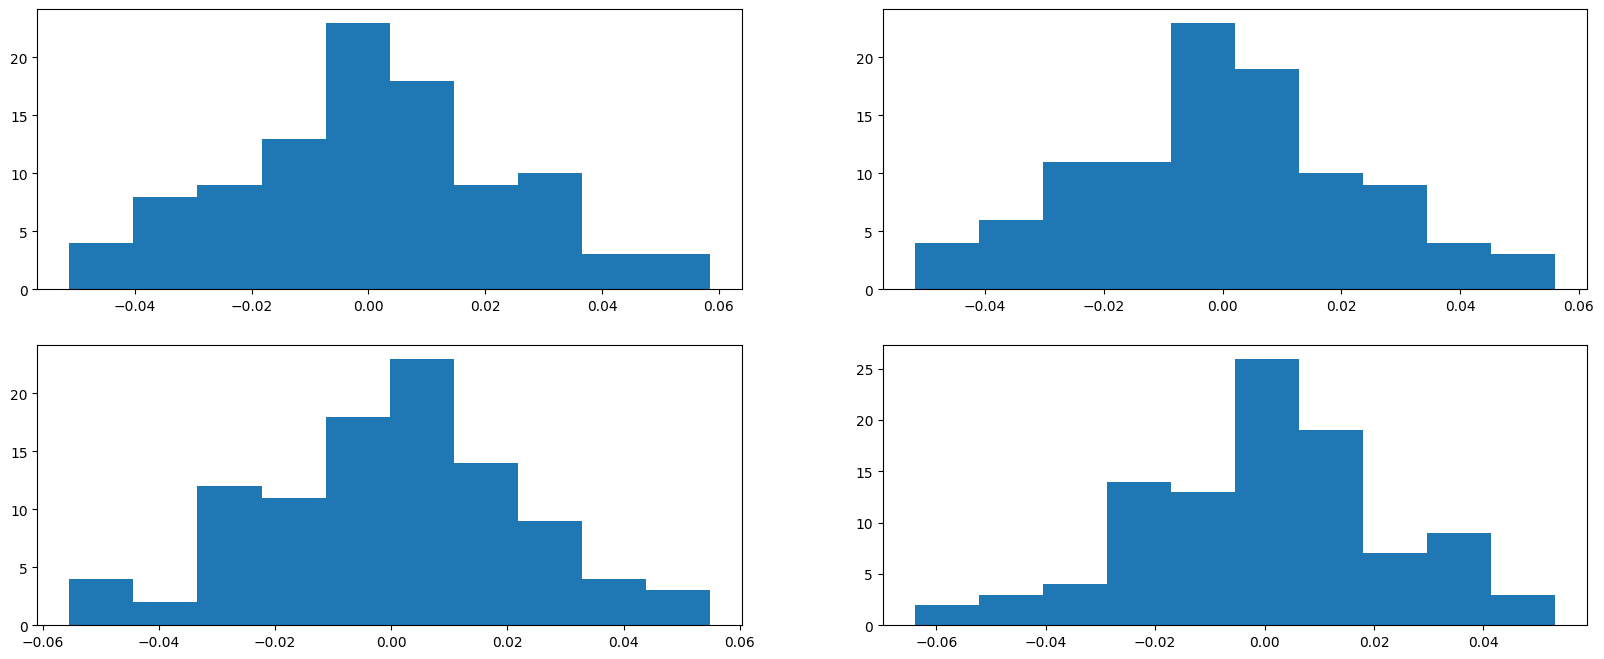

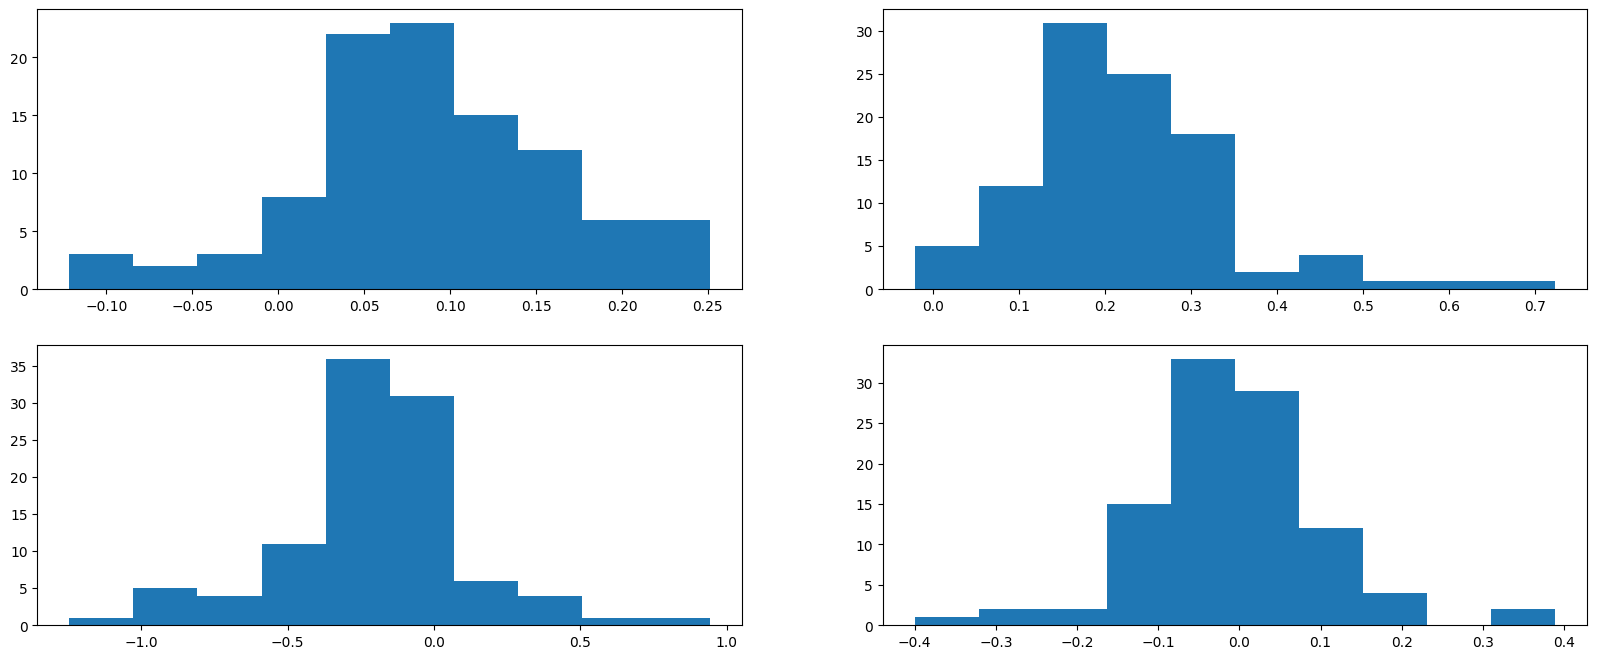

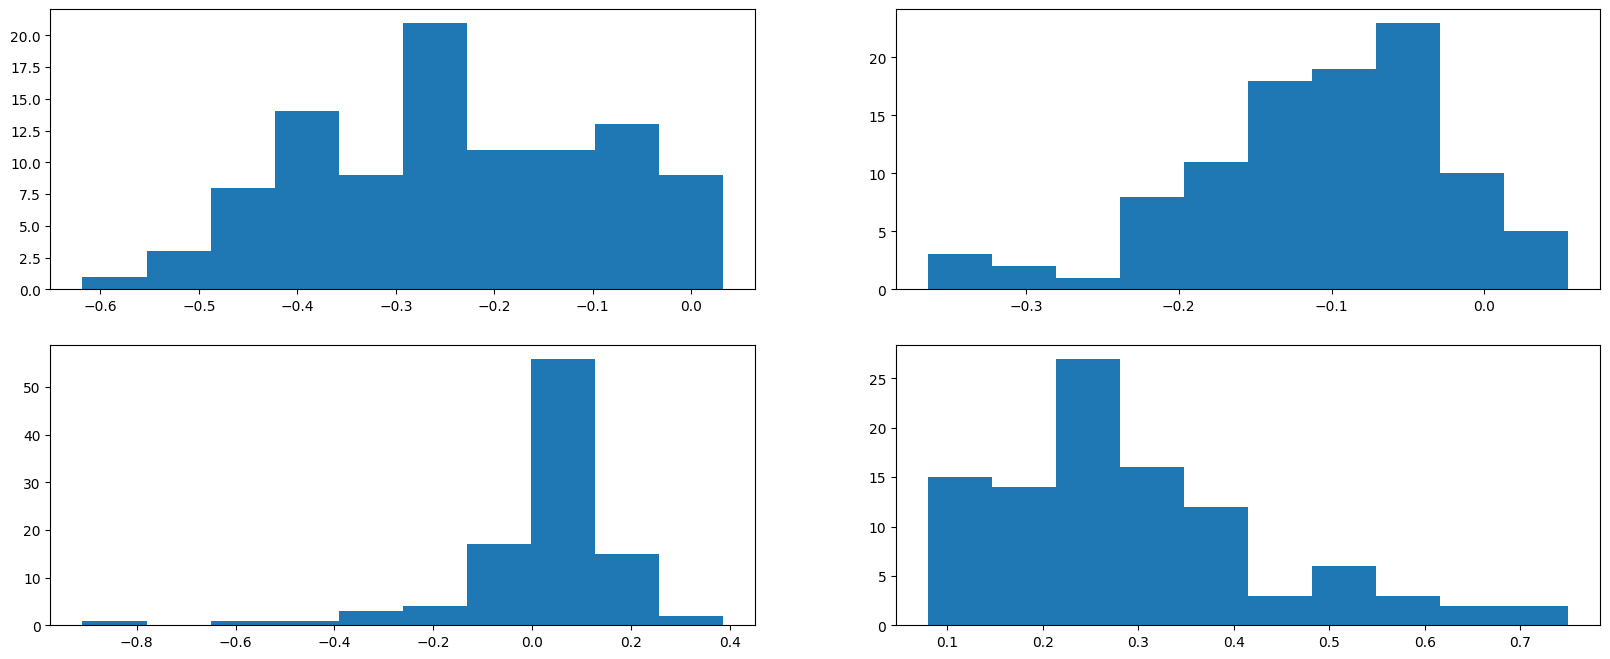

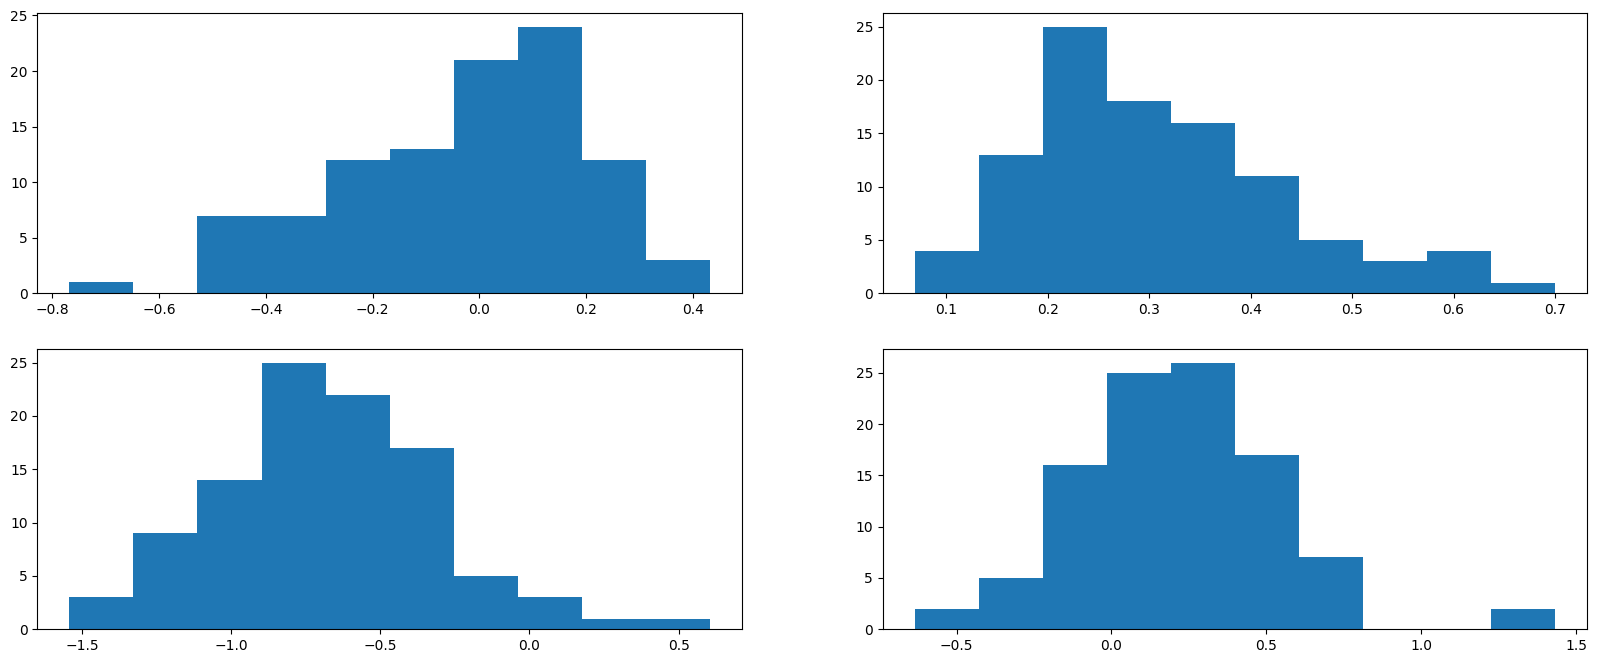

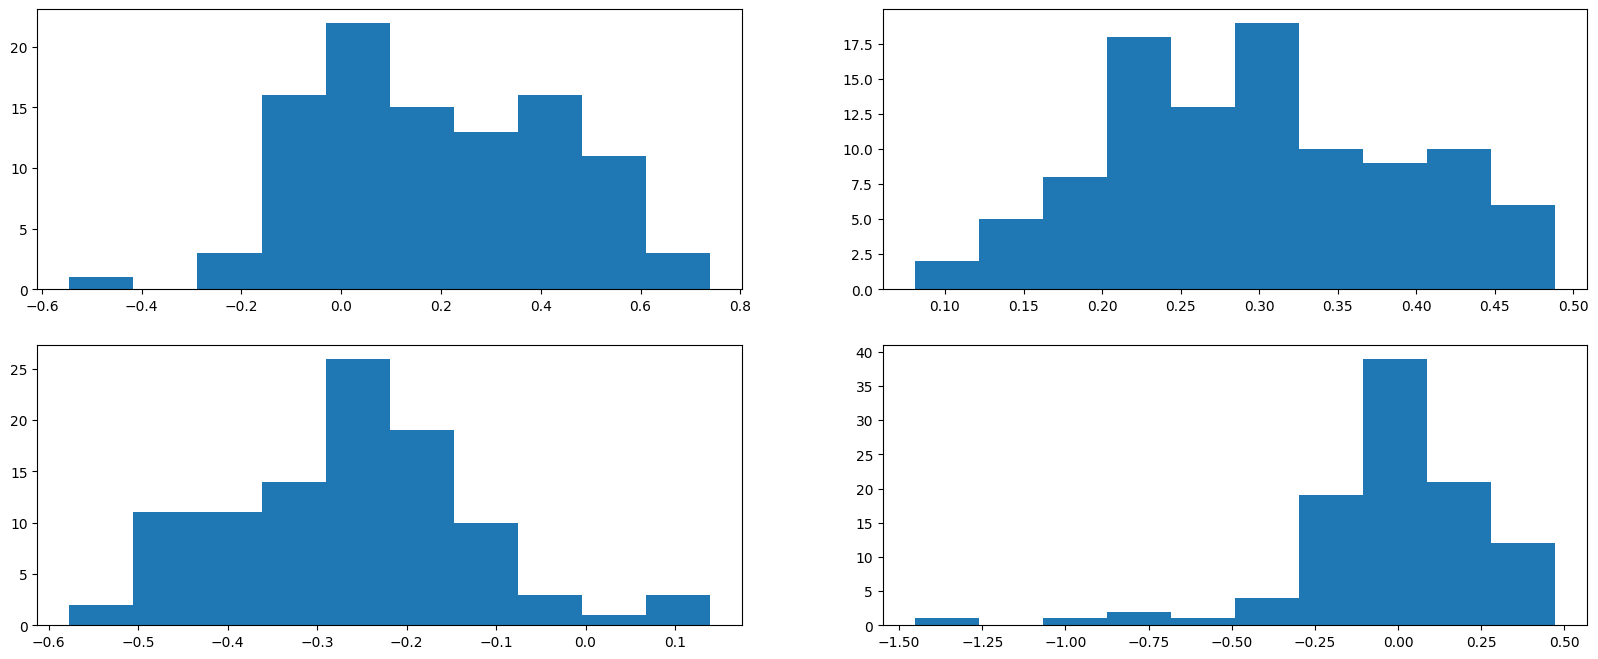

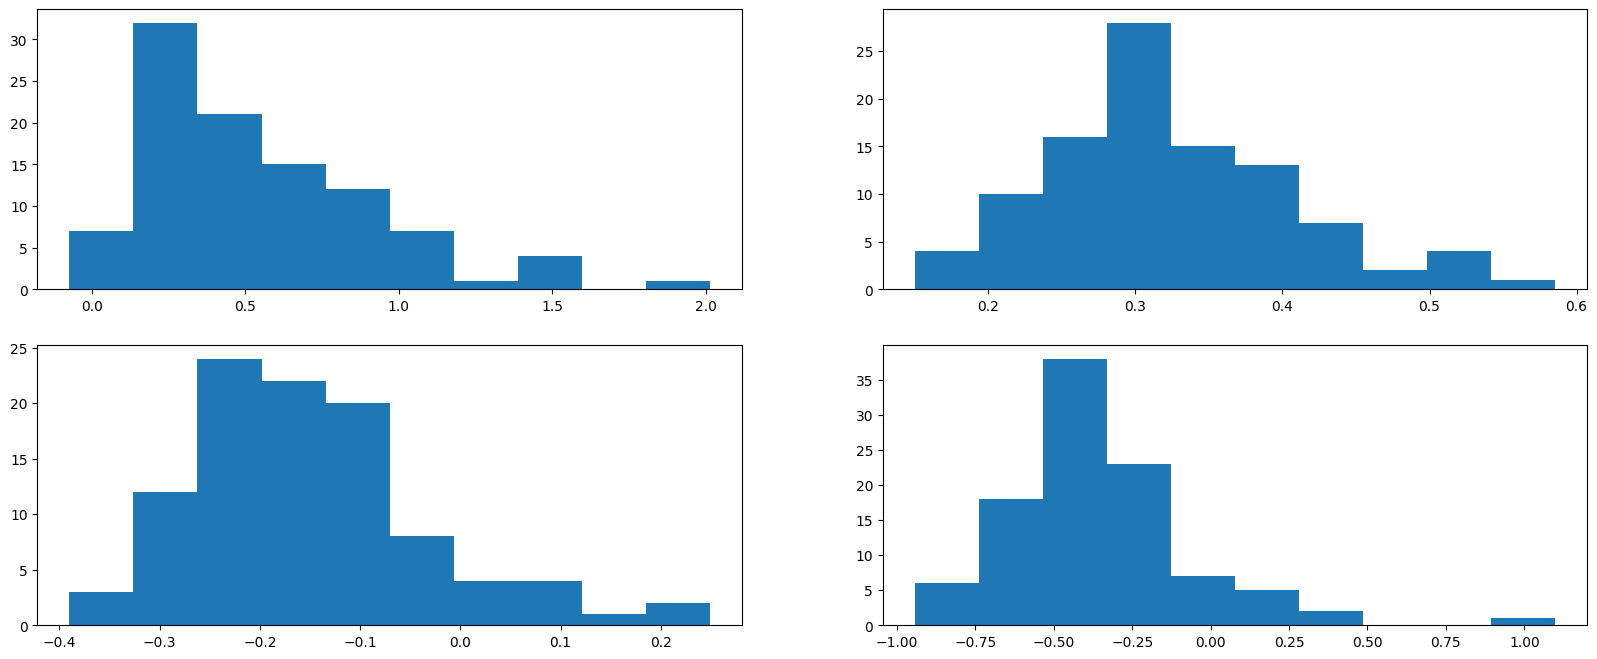

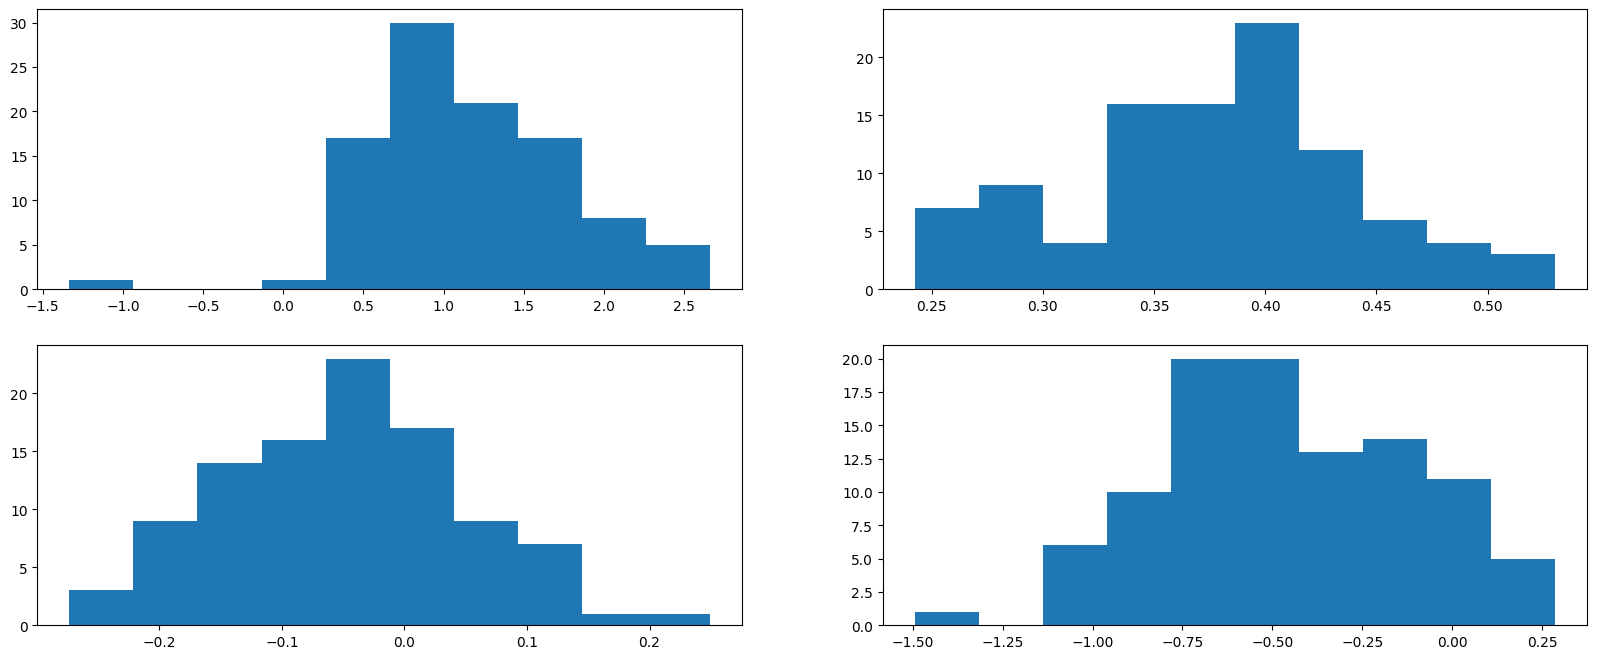

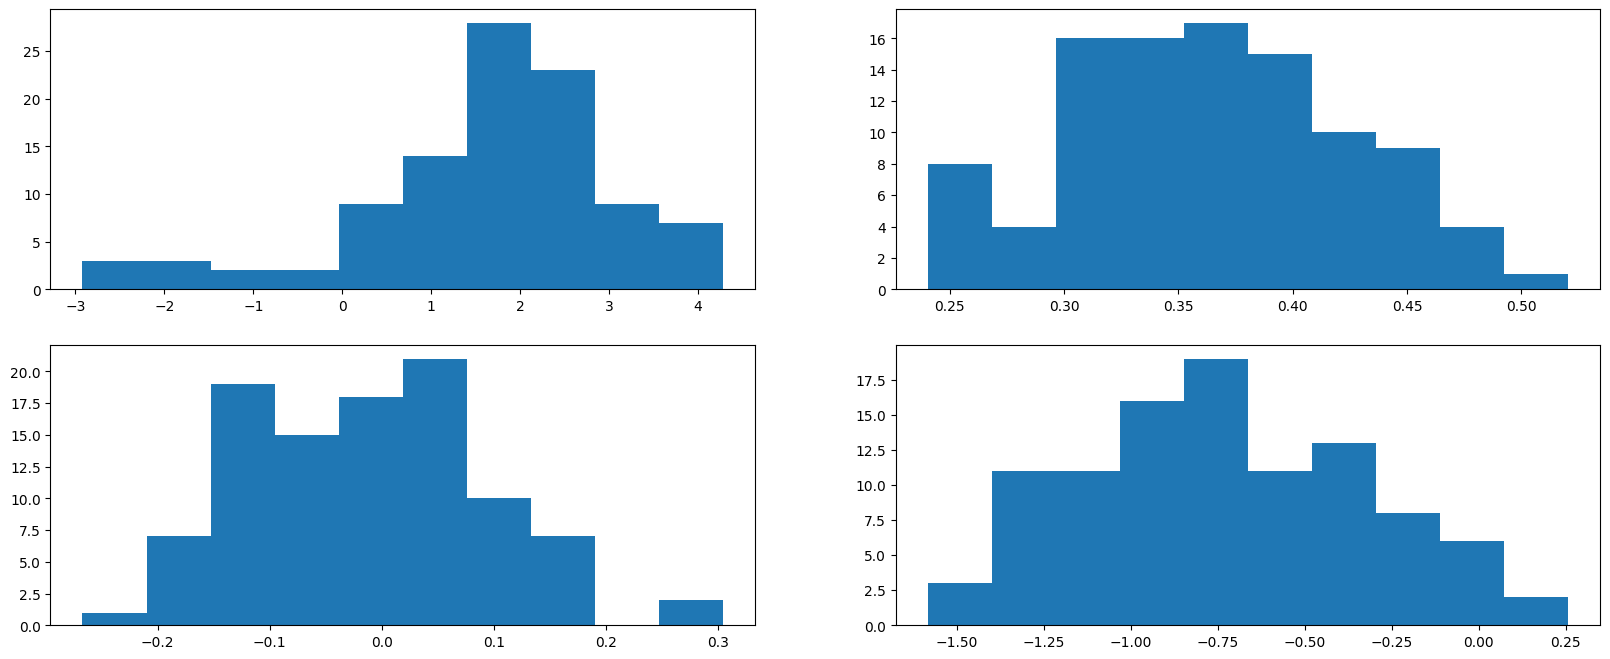

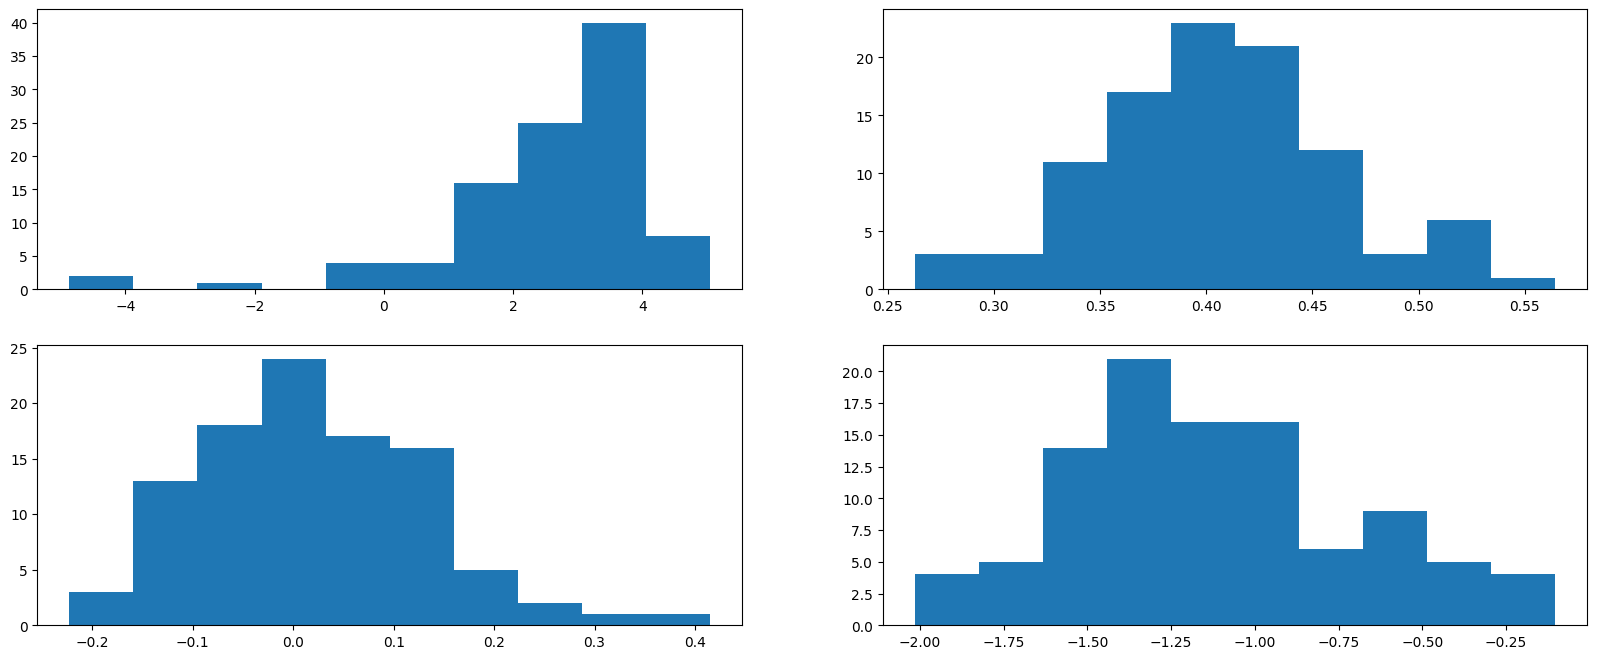

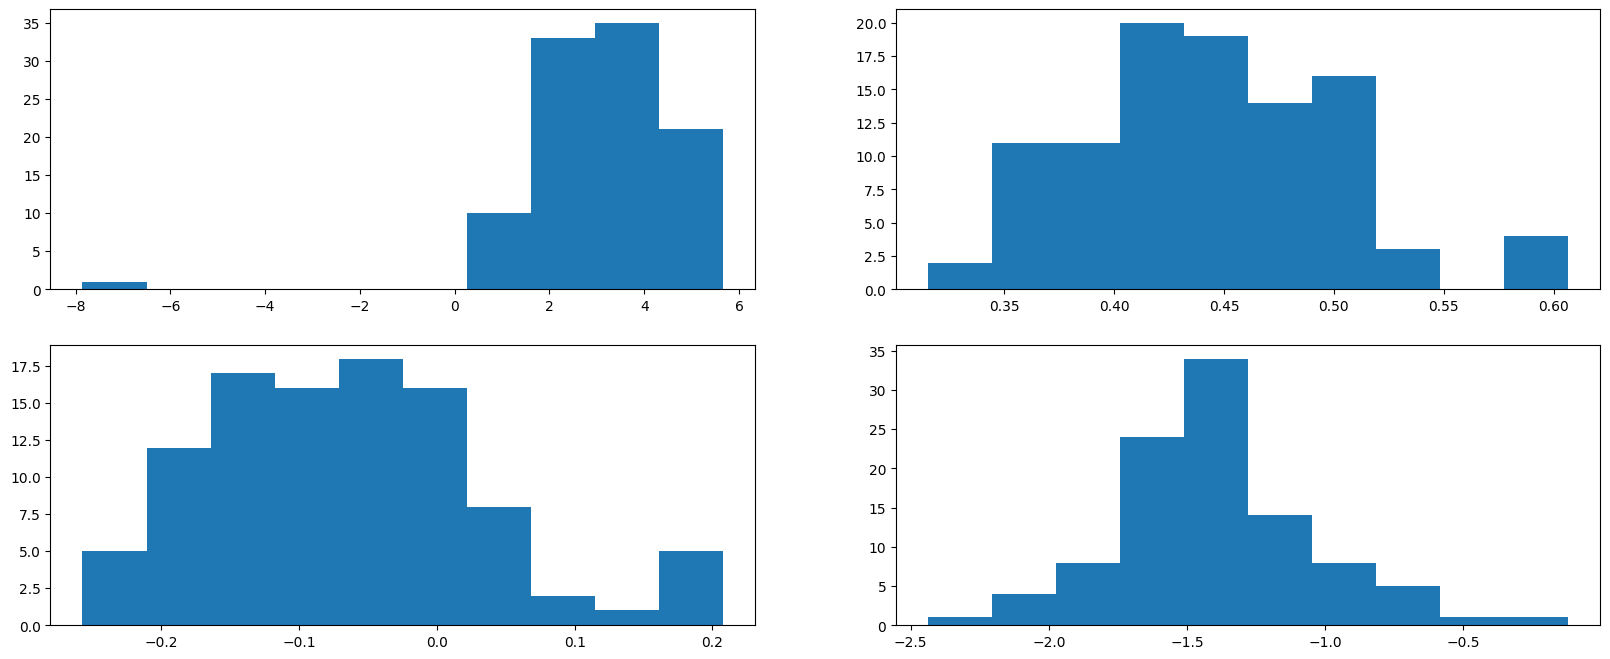

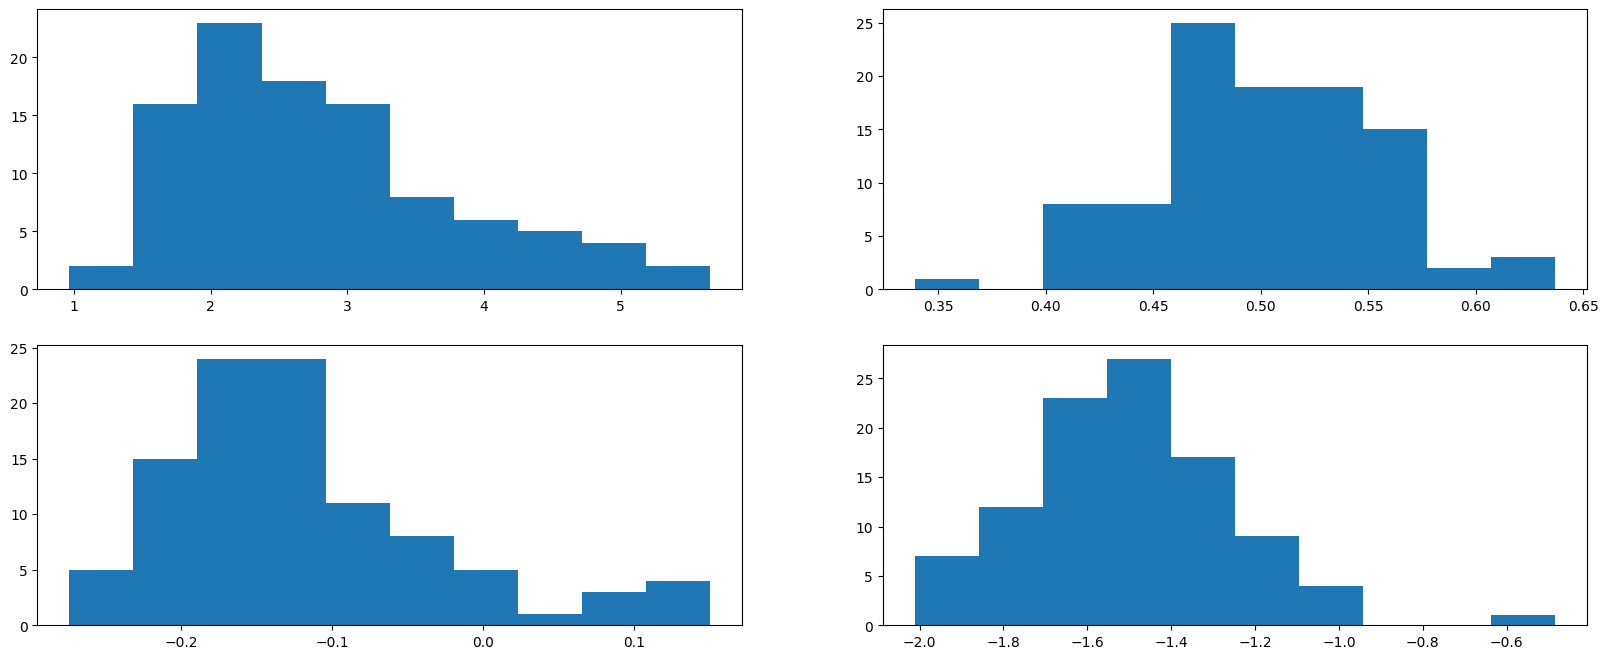

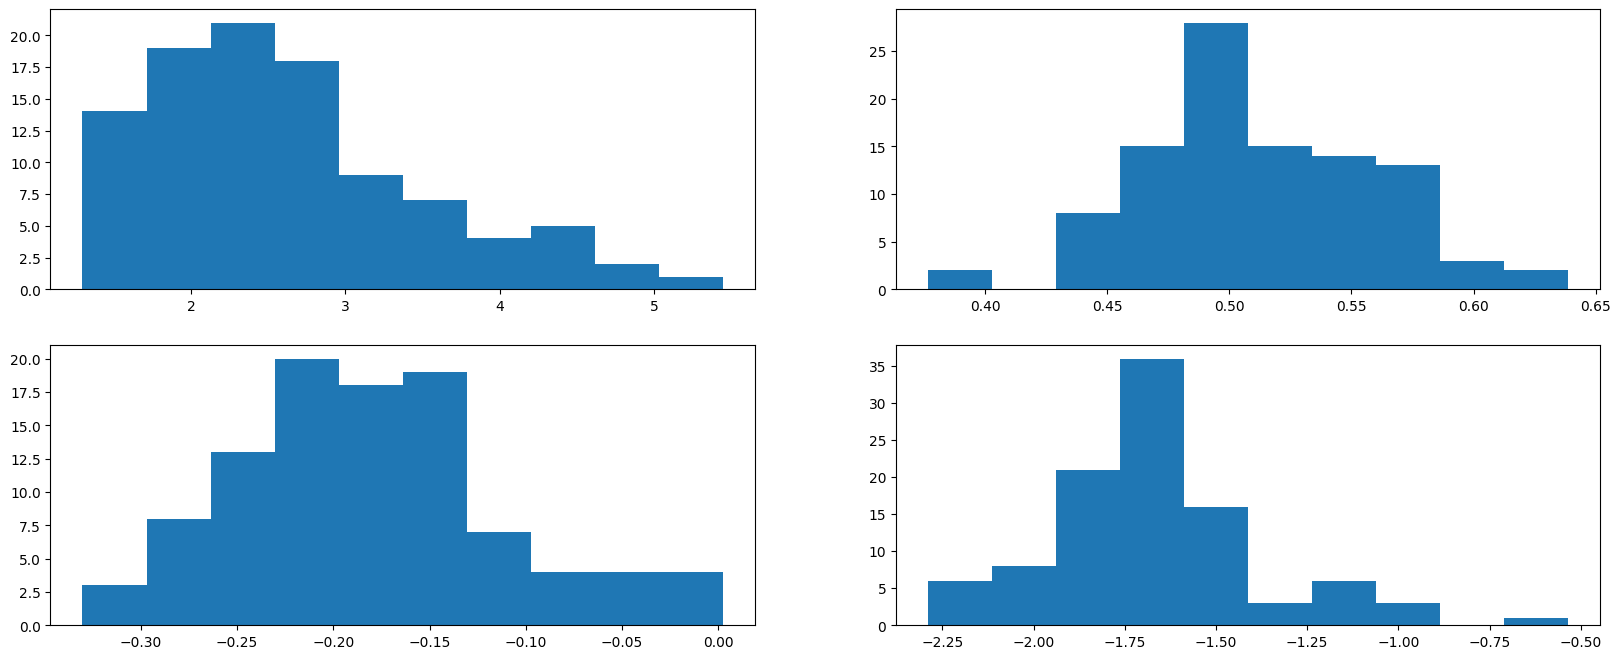

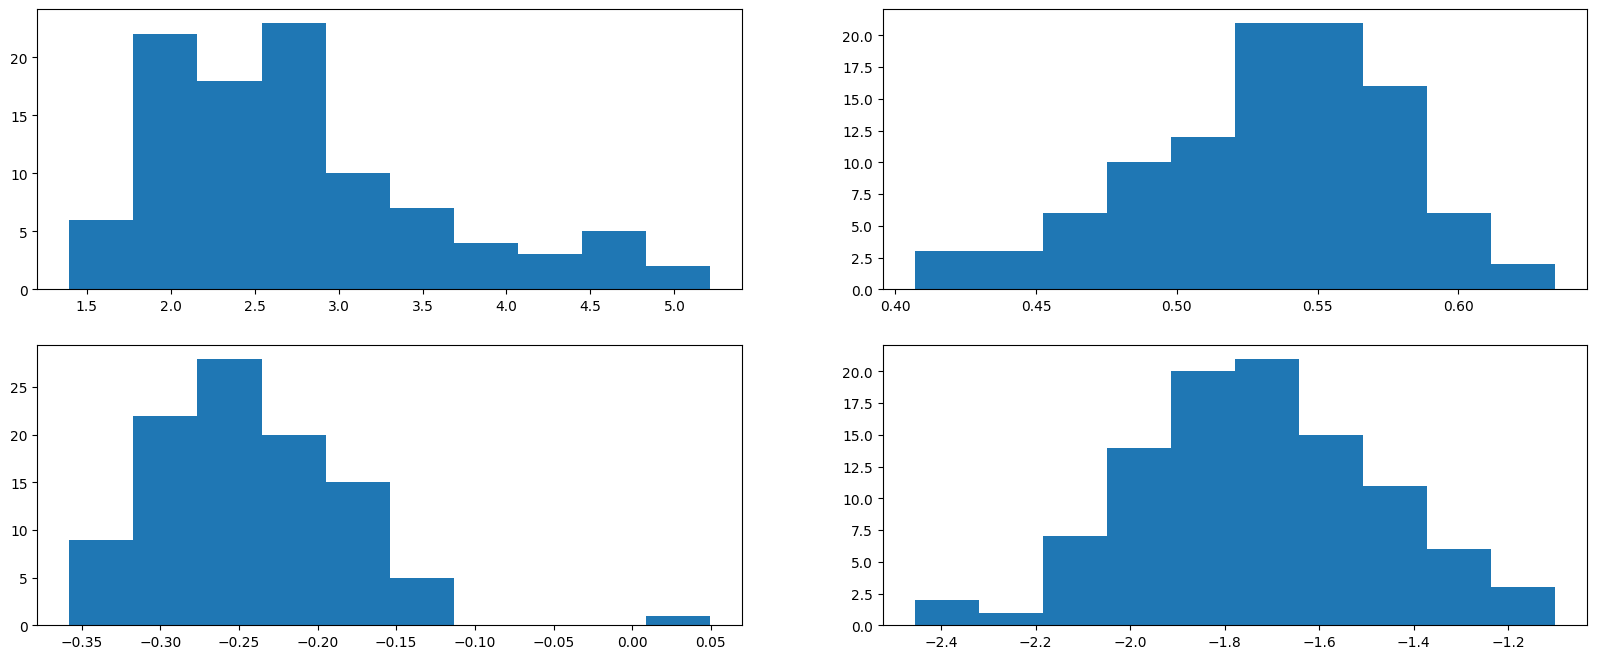

In [37]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(comment = '_test3_with_singlevar')

for i in range(num_epochs):

    EU, EF, KL_loss, total_loss = net.fit(X, t, U, no_samples = 20)
    
    fit_loss_U_train[i] = EU.item()
    fit_loss_F_train[i] = EF.item()
    KL_loss_train[i] = KL_loss.item()
    loss[i] = total_loss.item()

    writer.add_scalar("loss/total_loss", loss[i], i)
    writer.add_scalar("loss/U_loss", fit_loss_U_train[i], i)
    writer.add_scalar("loss/F_loss", fit_loss_F_train[i], i)
    writer.add_scalar("loss/KL_loss", KL_loss_train[i], i)
    

    if i % 2000 == 0:
        F_test = net.sample_F(X_u_test_25)
        fig, axs = plt.subplots(2, 2, figsize=(20, 8))
        axs[0,0].hist(F_test[:,0])
        axs[0,1].hist(F_test[:,100])
        axs[1,0].hist(F_test[:,150])
        axs[1,1].hist(F_test[:,255])
        plt.savefig('./plots/epoch{}.tiff'.format(i))


    if i % 100 == 0 or i == num_epochs - 1:

        print("Epoch: {:5d}/{:5d}, total loss = {:.3f}, Fit loss U = {:.3f}, Fit loss F = {:.3f}, KL loss = {:.3f}".format(i + 1, num_epochs, 
               loss[i], fit_loss_U_train[i], fit_loss_F_train[i], KL_loss_train[i]))

    
        lambda1_mus = net.lambda1_mus.item()
        lambda1_stds = torch.log(1 + torch.exp(net.lambda1_rhos)).item()
        
        lambda2_mus = np.exp(net.lambda2_mus.item())
        lambda2_stds = torch.log(1 + torch.exp(net.lambda2_rhos)).item()
        
        samples_25, _ = net.predict(X_u_test_25, 100, net.network)
        u_pred_25 = samples_25.mean(axis=0)
        error_25 = np.linalg.norm(target_25-u_pred_25, 2)/np.linalg.norm(target_25, 2)

        samples_train, _ = net.predict(X_u_train, 100, net.network)
        u_pred_train = samples_train.mean(axis=0)
        error_train = np.linalg.norm(u_train-u_pred_train, 2)/np.linalg.norm(u_train, 2)


        # writer.add_scalars("loss/train_test", {'train':error_train, 'test':error_25}, i)
        # writer.add_scalars("loss/f_u", {'noise_f':noise_f, 'noise_u':noise_u}, i)
       
        print("Epoch: {:5d}/{:5d}, lambda1_mu = {:.3f}, lambda2_mu = {:.3f}, lambda1_std = {:.3f}, lambda2_std = {:.3f}".format(i + 1, num_epochs,
                                                                                                                        lambda1_mus, lambda2_mus,
                                                                                                                        lambda1_stds, lambda2_stds))
        print("Epoch: {:5d}/{:5d}, error_25 = {:.5f}, error_train = {:.5f}".format(i+1, num_epochs, error_25, error_train))
        # print("Epoch: {:5d}/{:5d}, noise_f = {:.5f}, noise_u = {:.5f}".format(i+1, num_epochs, noise_f, noise_u))
        print()

writer.close()

In [38]:

x = data['x'].flatten()[:,None]
X_u_test_25 = np.hstack([x, 0.25*np.ones_like((x))]); u_test_25 = Exact[25]; u_mean_25 = Exact[25]
X_u_test_50 = np.hstack([x, 0.50*np.ones_like((x))]); u_test_50 = Exact[50]; u_mean_50 = Exact[50]
X_u_test_75 = np.hstack([x, 0.75*np.ones_like((x))]); u_test_75 = Exact[75]; u_mean_75 = Exact[75]


def get_res(X):
    samples, noises = net.predict(X, 100, net.network)
    u_pred = samples.mean(axis = 0)

    aleatoric = (noises**2).mean(axis = 0)**0.5
    epistemic = samples.var(axis = 0)**0.5
    total_unc = (aleatoric**2 + epistemic**2)**0.5
    return u_pred.ravel(), total_unc.ravel()*(u_ub-u_lb)


x = x.ravel()
u_pred_25, total_unc_25 = get_res(X_u_test_25)
u_pred_50, total_unc_50 = get_res(X_u_test_50)
u_pred_75, total_unc_75 = get_res(X_u_test_75)



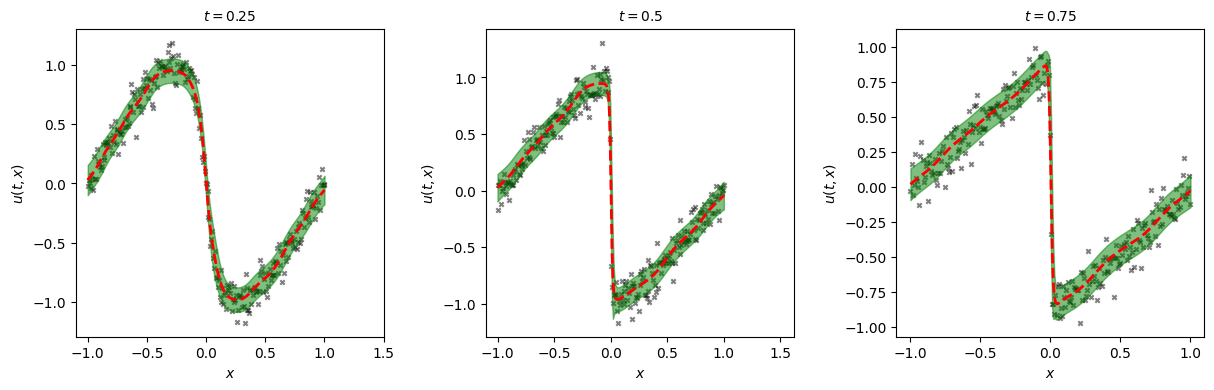

In [39]:

fig, axs = plt.subplots(1, 3, figsize = (15,4))
axs[0].scatter(x, u_test_25, s = 10, marker = 'x', color = 'black', alpha = 0.5, label = 'Exact')
axs[0].plot(x, u_mean_25, 'b-', linewidth = 2, label = 'Prediction')
axs[0].plot(x, u_pred_25, 'r--', linewidth = 2, label = 'Prediction')
axs[0].fill_between(x, u_pred_25-total_unc_25, u_pred_25+total_unc_25, color = 'g', alpha = 0.5, label = 'Epistemic + Aleatoric')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$u(t,x)$')
axs[0].set_title('$t = 0.25$', fontsize = 10)
axs[0].axis('square')
#ax.set_xlim([-1.1,1.1])
#ax.set_ylim([-1.1,1.1])


axs[1].scatter(x, u_test_50, s = 10, marker = 'x', color = 'black', alpha = 0.5, label = 'Exact')
axs[1].plot(x, u_mean_50, 'b-', linewidth = 2, label = 'Prediction')
axs[1].plot(x, u_pred_50, 'r--', linewidth = 2, label = 'Prediction')
axs[1].fill_between(x, u_pred_50-total_unc_50, u_pred_50+total_unc_50, color = 'g', alpha = 0.5, label = 'Epistemic + Aleatoric')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$u(t,x)$')
axs[1].set_title('$t = 0.5$', fontsize = 10)
axs[1].axis('square')


axs[2].scatter(x, u_test_75, s = 10, marker = 'x', color = 'black', alpha = 0.5, label = 'Exact')
axs[2].plot(x, u_pred_75, 'r--', linewidth = 2, label = 'Prediction')
axs[2].fill_between(x, u_pred_75-total_unc_75, u_pred_75+total_unc_75, color = 'g', alpha = 0.5, label = 'Epistemic + Aleatoric')
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$u(t,x)$')
axs[2].set_title('$t = 0.75$', fontsize = 10)
axs[2].axis('square')

plt.savefig('./plots/final_prediction.tiff')


In [40]:
for name, param in net.network.named_parameters():
    print(name, param)
    

lambda1_mu Parameter containing:
tensor([0.9325], device='cuda:0', requires_grad=True)
lambda2_mu Parameter containing:
tensor([-5.1144], device='cuda:0', requires_grad=True)
lambda1_rho Parameter containing:
tensor([-6.2258], device='cuda:0', requires_grad=True)
lambda2_rho Parameter containing:
tensor([-6.0647], device='cuda:0', requires_grad=True)
layer1.weight_mus Parameter containing:
tensor([[-9.3387e-04,  2.6093e-01,  1.2853e-03, -2.8089e-03,  5.4978e-04,
         -7.3121e-02,  3.2269e-03, -2.0658e-01, -5.4699e-04,  1.2448e-03,
         -3.5825e-03, -1.5877e-01, -9.7354e-03, -9.9373e-04,  1.1763e-03,
         -7.0435e-04,  1.7729e-03,  1.6342e-01, -2.1984e-03, -4.8209e-03,
         -8.0671e-04,  5.5581e-02,  4.4688e-03,  1.2514e+00, -4.7311e-03,
          1.8406e-03,  6.8606e-02,  2.8283e-03, -3.2343e-01,  1.8313e-03,
          1.0100e-03,  2.3704e-03,  2.9700e-03,  2.0052e-03, -2.9119e-03,
         -1.0986e-01,  1.0003e-03, -2.8177e-03, -7.2717e-04, -3.2899e-03,
          5.395